# Setup

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
%matplotlib inline

# plotting cities and tour
def plot_tsp(df, tour=None, open_tour=False):
    plt.figure(figsize=(10,10))
    plt.scatter(df.x, df.y)
    if tour:
        for i, j in tour:
            x1 = df.loc[i]['x']
            x2 = df.loc[j]['x']
            y1 = df.loc[i]['y']
            y2 = df.loc[j]['y']
            plt.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['id'])
            plt.text(df.loc[j]['x'], df.loc[j]['y'], df.loc[j]['id'])
            x = [x1, x2]
            y = [y1, y2]
            if j == 0:
                if not open_tour:
                    plt.plot(x, y, 'r')
            else:
                plt.plot(x, y, 'b')

# Ler dataset

In [2]:
filename = '15_cidades.csv'
df = pd.read_csv(filename)
matriz_distancias = squareform(pdist(df))

# Mostrar cidades nas coordenadas X,Y

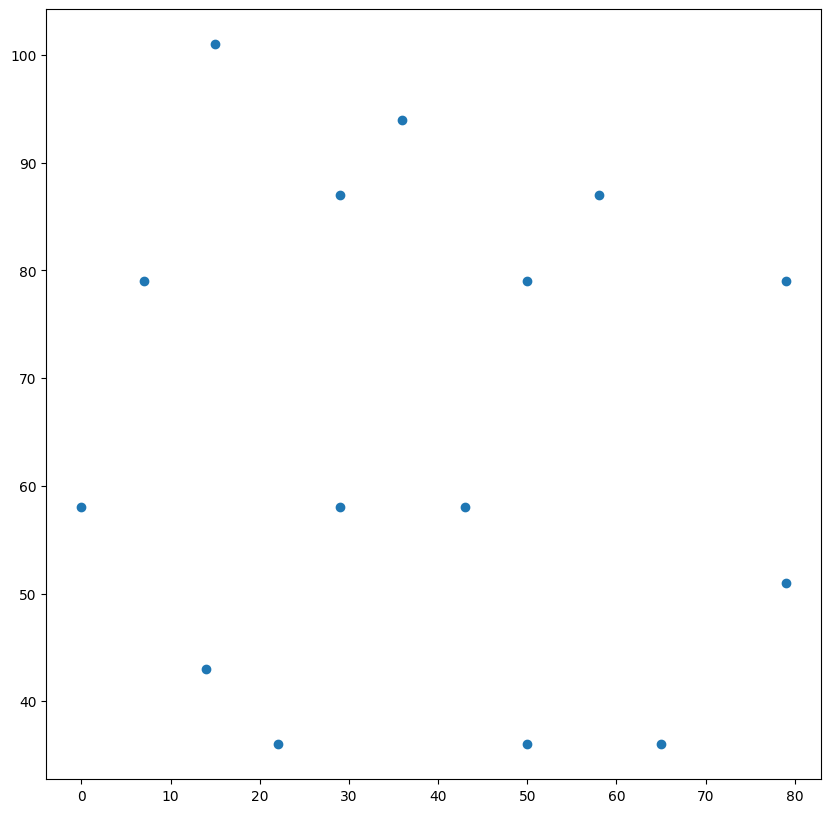

In [3]:
plot_tsp(df)

# Definindo Funcao Para Resolver o Caixeiro Viajante pelo modelo de Miller Tucker Zemlin (1960)

In [4]:
def caixeiro_MTZ(dataset, matriz_distancias):
    # numero de cidades
    N = dataset.shape[0]
    # numero de cidades a serem visitadas (inclusa a origem)
    P = N
    # definindo o solver
    solver = pywraplp.Solver.CreateSolver('SAT')
    # definindo variaveis de decisão X e U
    x, u = {}, {}
    for i in range(N):
        u[i] = solver.IntVar(0, P, 'u_{}'.format(i))
        for j in range(N):
            x[i, j] = solver.IntVar(0, 1, 'x_{},{}'.format(i, j))
    # adicionando as restricoes
    # removendo auto-conexões (loops)
    for i in range(N):
        solver.Add(x[i,i] == 0)
    # que você não entre em nenhuma cidade mais do que uma vez
    for j in range(N):
        solver.Add(solver.Sum(x[i,j] for i in range(N)) == 1)
    # que você não saia de qualquer cidade mais do que uma vez
    for i in range(N):
        solver.Add(solver.Sum(x[i,j] for j in range(N)) == 1)
    # evitando que subciclos sejam colocados como soluções validas
    for i in range(N):
        for j in range(N):
            # se considerarmos a origem, então, nenhuma solução será valida
            # pois o ciclo com a origem também é um subciclo
            # portanto, a origem deve ser desconsiderada
            if j != 0: 
                solver.Add(u[i] - u[j] + P*x[i,j] <= P - 1)
    # adiciona a funcao objetivo
    f = solver.Sum([x[i, j] * matriz_distancias[i, j] for j in range(N) for i in range(N)])
    solver.Minimize(f)
    # resolve o problema
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        distancia = solver.Objective().Value()
        tour = [(i, j) for i in range(N) for j in range(N) if x[i,j].solution_value() == 1]
        
        # construir rota
        rota = [1]
        origem = 0
        destino = None
        while destino != 0:
            destino = tour[origem][1]
            origem = destino
            rota.append(destino + 1)
        print('Distância: {} milhas'.format(distancia))
        print('Rota: {}'.format(rota))
        plot_tsp(dataset, tour)
    else:
        print('Nao existe solucao factivel')

Distância: 303.8216209001168 milhas
Rota: [1, 13, 2, 15, 9, 5, 7, 3, 12, 14, 10, 8, 6, 4, 11, 1]


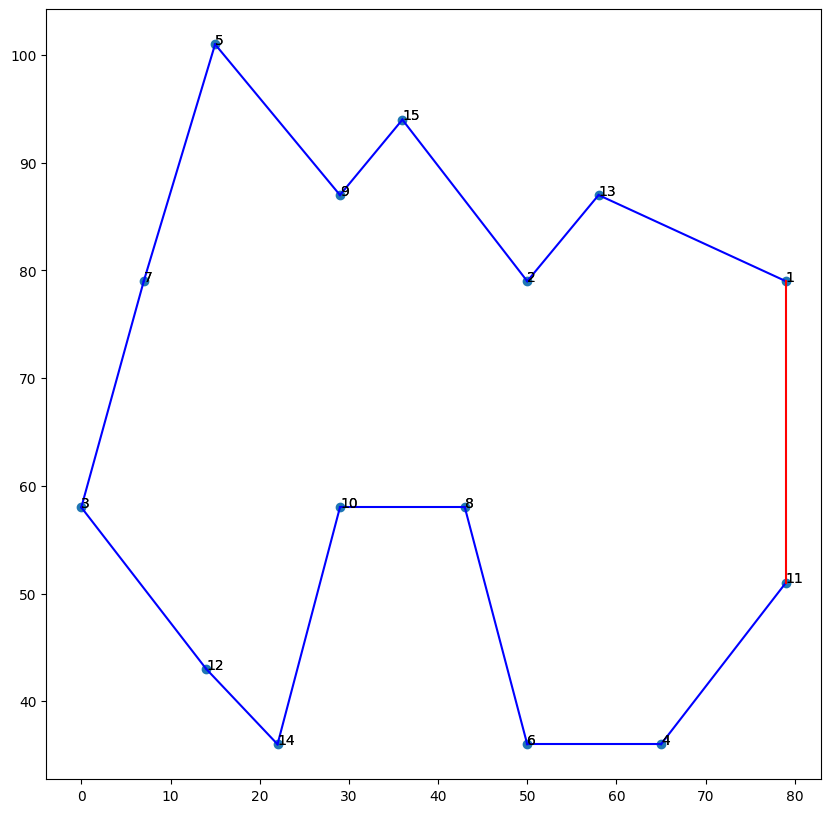

In [5]:
caixeiro_MTZ(df, matriz_distancias)